In [1]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")


# definzioni funzioni varie

def timeserieFeatureExtractor(timeseries):
    timeseries['dayofweek'] = timeseries.index.dayofweek
    timeseries['quarter'] = timeseries.index.quarter
    timeseries['dayofyear'] = timeseries.index.dayofyear
    timeseries['dayofmonth'] = timeseries.index.day
    timeseries['weekofyear'] = timeseries.index.weekofyear
#     timeseries['daysinmonth'] = timeseries.index.daysinmonth
#     timeseries['month'] = timeseries.index.month
#     timeseries['year'] = timeseries.index.year
    timeseries['weekend'] = np.where(timeseries.index.dayofweek > 4, 1, 0)
    timeseries.fillna(0,inplace=True)
    return 

def calcError(y_test, y_pred):
#     R2 = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = sqrt(MSE)
    MAE = mean_absolute_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
#     print(f'R2: {round(R2,4)}')
    print(f'Mean Squared Error: {round(MSE,4)}')
    print(f'Root Mean Sqarred Error: {round(RMSE,4)}')
    print(f'Mean Absolute Error: {round(MAE,4)}')
    print(f'Mean Absolute Percentage Error: {round(MAPE*100,4)}')
    return

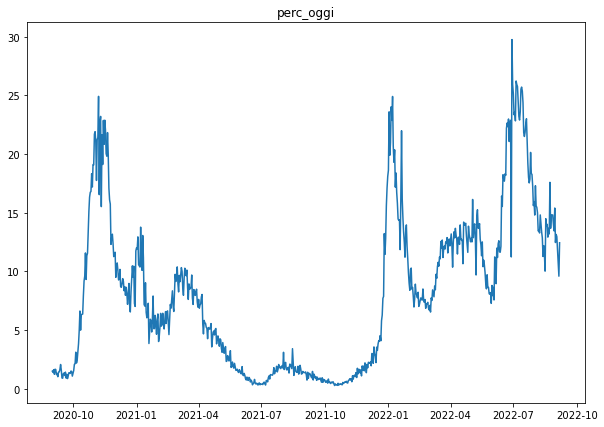

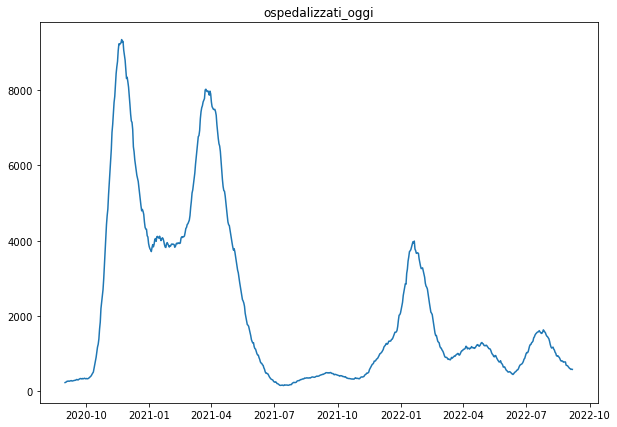

,perc_oggi,ospedalizzati_oggi,ospedalizzati_past1,ospedalizzati_past2,ospedalizzati_past3,ospedalizzati_past4,ospedalizzati_past5,ospedalizzati_past6,perc_past1,perc_past2,...,perc_past4,perc_past5,perc_past6,ospedalizzati_target,dayofweek,quarter,dayofyear,dayofmonth,weekofyear,weekend
date,,,,,,,,,,,,,,,,,,,,,
2022-08-28,14.705714,694.0,780.0,780.0,780.0,775.0,800.0,810.0,14.650000,14.380000,...,14.137143,14.254286,13.172857,582.0,6,3,240,28,34,1
2022-08-29,14.742857,688.0,694.0,780.0,780.0,780.0,775.0,800.0,14.705714,14.650000,...,14.265714,14.137143,14.254286,588.0,0,3,241,29,35,0
2022-08-30,14.430000,680.0,688.0,694.0,780.0,780.0,780.0,775.0,14.742857,14.705714,...,14.380000,14.265714,14.137143,583.0,1,3,242,30,35,0
2022-08-31,14.257143,655.0,680.0,688.0,694.0,780.0,780.0,780.0,14.430000,14.742857,...,14.650000,14.380000,14.265714,0.0,2,3,243,31,35,0
2022-09-01,14.020000,627.0,655.0,680.0,688.0,694.0,780.0,780.0,14.257143,14.430000,...,14.705714,14.650000,14.380000,0.0,3,3,244,1,35,0
2022-09-02,13.755714,609.0,627.0,655.0,680.0,688.0,694.0,780.0,14.020000,14.257143,...,14.742857,14.705714,14.650000,0.0,4,3,245,2,35,0
2022-09-03,13.324286,600.0,609.0,627.0,655.0,680.0,688.0,694.0,13.755714,14.020000,...,14.430000,14.742857,14.705714,0.0,5,3,246,3,35,1
2022-09-04,12.841429,582.0,600.0,609.0,627.0,655.0,680.0,688.0,13.324286,13.755714,...,14.257143,14.430000,14.742857,0.0,6,3,247,4,35,1
2022-09-05,12.290000,588.0,582.0,600.0,609.0,627.0,655.0,680.0,12.841429,13.324286,...,14.020000,14.257143,14.430000,0.0,0,3,248,5,36,0


In [2]:
# dataframe from lombacovid.it
data = pd.read_csv('https://www.lombacovid.it/story.csv',usecols = ['data','perc_story','ospedalizzati_story'])
data['data'] = pd.to_datetime(data['data'], dayfirst=True)

data.rename(columns = {'ospedalizzati_story':'ospedalizzati_oggi',
                       'perc_story':'perc_oggi',
                       'data':'date'},
                            inplace = True)
data.set_index('date',inplace=True)

for i in data:
    plt.figure(figsize=(10,7))
    plt.plot(data[i])
    plt.title(i)
    plt.show()
    
# 1) feature engineering 
# perc_oggi smoothed by running average of 7 days
running_average = 7     
data['perc_oggi'] = data['perc_oggi'].rolling(window=running_average).mean()
data = data.dropna()

# ospedalizzati and perc_oggi lag features shifted by 10 days: t, t+1, ... t+n
past_days = 7           # <---
for i in range(1, past_days):
    data[f'ospedalizzati_past{i}'] = data['ospedalizzati_oggi'].shift(i).fillna(0)
for i in range(1, past_days):
    data[f'perc_past{i}'] = data['perc_oggi'].shift(i).fillna(0)

# of the target: ospedalizzati_oggi lagged by 7 days in the future: t-7
future_target = 7       # <---
data['ospedalizzati_target'] = data['ospedalizzati_oggi'].shift(-future_target).fillna(0)
data = data.fillna(0)

# 2) feature extraction
timeserieFeatureExtractor(data)

data.tail(10)

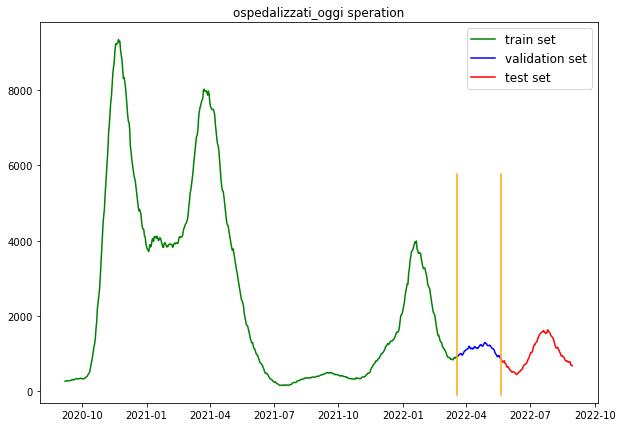

In [3]:
# train, test and validation length
len_train_train_test = int(len(data.index)-len(data.index)*15/100)
separation_index_train_test = list(data.index)[len_train_train_test]

len_train_val = int(len_train_train_test-len_train_train_test*10/100)
separation_index_train_val = list(data.index)[len_train_val]

separation_index_prediction = data.index[:-7][-1]

# feature splitting and plot
X = data.drop(columns='ospedalizzati_target')
X_train = X[X.index < separation_index_train_val]
X_val = X[(X.index > separation_index_train_val) & (X.index <= separation_index_train_test)]
X_test = X[(X.index > separation_index_train_test) & (X.index <= separation_index_prediction)]

plt.figure(figsize=(10,7))
plt.plot(X_train['ospedalizzati_oggi'],color='green',label='train set')
plt.plot(X_val['ospedalizzati_oggi'],color='blue',label='validation set')
plt.plot(X_test['ospedalizzati_oggi'],color='red',label='test set')
plt.axvline(x=separation_index_train_test, ymin = 0.02, ymax = 0.6, color='orange')
plt.axvline(x=separation_index_train_val, ymin = 0.02, ymax = 0.6, color='orange')
plt.title('ospedalizzati_oggi speration')
plt.legend(prop={'size': 12})
plt.show()

# target splitting
y = data['ospedalizzati_target']
y_train = y[y.index < separation_index_train_val]
y_val = y[(y.index > separation_index_train_val) & (data.index <= separation_index_train_test)]
y_test = y[(y.index > separation_index_train_test) & (y.index <= separation_index_prediction)]

[0]	validation_0-rmse:3312.02586	validation_1-rmse:1012.90236
[1]	validation_0-rmse:2995.89642	validation_1-rmse:934.46694
[2]	validation_0-rmse:2711.00022	validation_1-rmse:862.71869
[3]	validation_0-rmse:2453.36181	validation_1-rmse:719.85647
[4]	validation_0-rmse:2220.43774	validation_1-rmse:660.80565
[5]	validation_0-rmse:2010.23239	validation_1-rmse:607.40453
[6]	validation_0-rmse:1818.96376	validation_1-rmse:556.46928
[7]	validation_0-rmse:1647.82602	validation_1-rmse:509.58095
[8]	validation_0-rmse:1492.28105	validation_1-rmse:468.68437
[9]	validation_0-rmse:1352.55278	validation_1-rmse:366.11705
[10]	validation_0-rmse:1226.35895	validation_1-rmse:317.75377
[11]	validation_0-rmse:1111.80421	validation_1-rmse:282.08363
[12]	validation_0-rmse:1007.57208	validation_1-rmse:238.84078
[13]	validation_0-rmse:914.18665	validation_1-rmse:231.46877
[14]	validation_0-rmse:828.71364	validation_1-rmse:215.95349
[15]	validation_0-rmse:752.47613	validation_1-rmse:228.51364
[16]	validation_0-rm

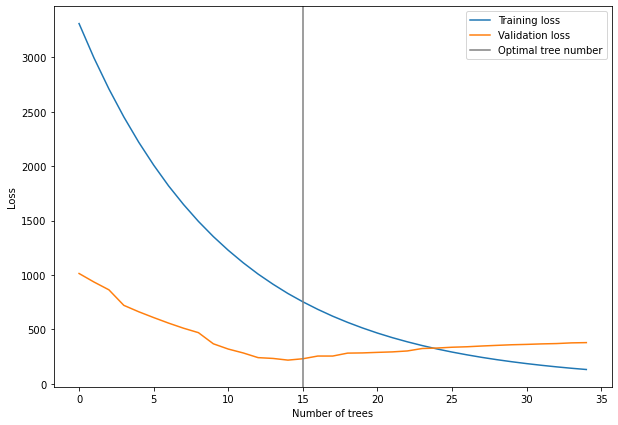

best trees numb: 15


In [4]:
# -> xgboost regressor
# early stopping rounds for xgboost
model = XGBRegressor(n_estimators=250, 
                         max_depth=6, 
                         learning_rate=0.1)
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_val, y_val)], 
          early_stopping_rounds=20,
          verbose=True) 

# plot n° trees (x) vs loss function: rmse (y)
results = model.evals_result()
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(model.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
plt.show()


best_numb_trees = model.best_ntree_limit
print(f'best trees numb: {best_numb_trees}')

Error on validation data
Mean Squared Error: 66497.6486
Root Mean Sqarred Error: 257.8714
Mean Absolute Error: 226.2689
Mean Absolute Percentage Error: 20.2602


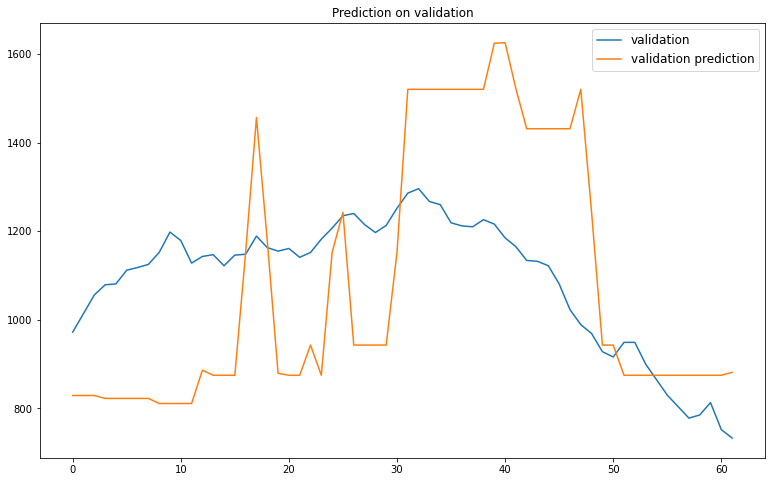

Error on test data
Mean Squared Error: 822532.1768
Root Mean Sqarred Error: 906.9356
Mean Absolute Error: 698.6515
Mean Absolute Percentage Error: 72.1225


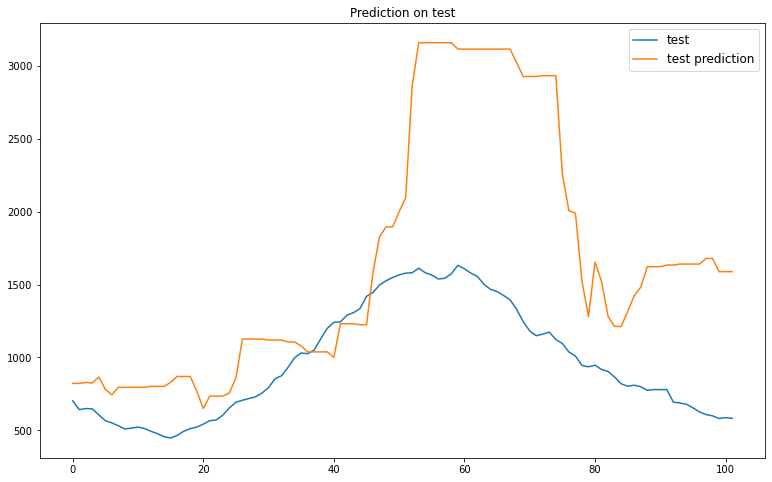

In [5]:
# -> fitting the model
model = XGBRegressor(
#                      booster = 'gbtree',
#                      eval_metric = 'rmse',
#                      objective = 'reg:squarederror',
                     eta = 0.1,
                     min_child_weight = 1,
                     max_depth = 6,
                     max_delta_step = 0,
                     subsample = 1,
                     colsample_bytree = 0.5,
                     colsample_bylevel = 1,
                     gamma = 1,
                     reg_lambda = 0.4,
                     reg_alpha = 0,
                     n_estimators = best_numb_trees,
                     seed = 42)

model.fit(X_train, y_train)



# prediction of validation set
y_pred_val = model.predict(X_val)

# error on validation on the first prediction 
print('Error on validation data')
calcError(y_val,y_pred_val)

# plot train vs val
plt.figure(figsize=(13,8))
plt.plot(y_val.values,label='validation')
plt.plot(y_pred_val,label='validation prediction')
plt.legend(prop={'size': 12})
plt.title('Prediction on validation')
plt.show()



# prediction of test set
y_pred_test = model.predict(X_test)

# error on test on the first prediction 
print('Error on test data')
calcError(y_test,y_pred_test)

# plot train vs val
plt.figure(figsize=(13,8))
plt.plot(y_test.values,label='test')
plt.plot(y_pred_test,label='test prediction')
plt.legend(prop={'size': 12})
plt.title('Prediction on test')
plt.show()


Error on validation data after tuning hyperparams
Mean Squared Error: 131819.275
Root Mean Sqarred Error: 363.0692
Mean Absolute Error: 327.7913
Mean Absolute Percentage Error: 28.8026


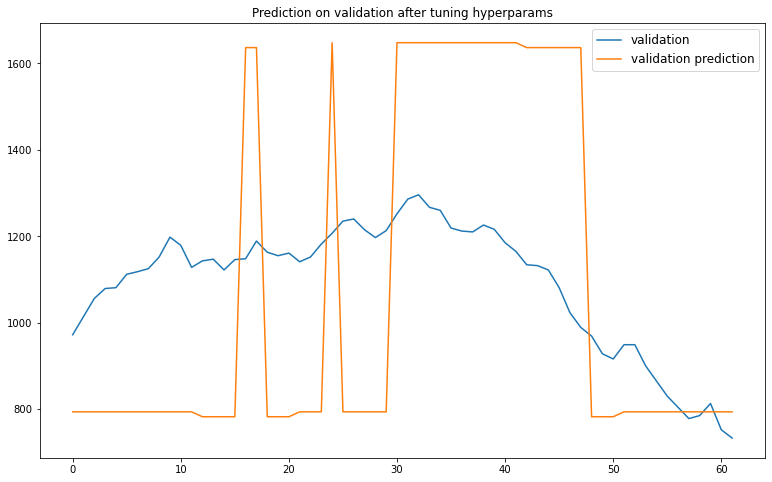

Error on test data after tuning hyperparams
Mean Squared Error: 418586.8658
Root Mean Sqarred Error: 646.9829
Mean Absolute Error: 537.5453
Mean Absolute Percentage Error: 57.7093


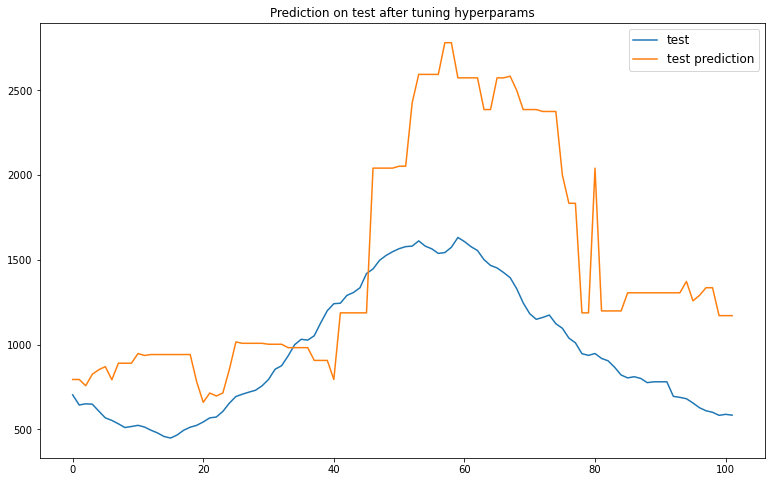

In [7]:
# -> tuning xgb parameters
# GridSeadchCV 
parameters = {'max_depth':[4,5,6,7],
              'eta':[0.09,0.1,0.11],
              'reg_lambda' : [0.35,0.4,0.45],
              'colsample_bytree' : [0.5,0.55,0.6,0.8]}

clf = GridSearchCV(model, 
                   parameters,
                   scoring = 'neg_mean_squared_error',verbose = False)

clf.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose = False)

best_estimator = clf.best_estimator_



# prediction of validation after tuning
tune_y_val_pred = best_estimator.predict(X_val)

# error on validation on the first prediction 
print('Error on validation data after tuning hyperparams')
calcError(y_val,tune_y_val_pred)

# plot train vs val
plt.figure(figsize=(13,8))
plt.plot(y_val.values,label='validation')
plt.plot(tune_y_val_pred,label='validation prediction')
plt.legend(prop={'size': 12})
plt.title('Prediction on validation after tuning hyperparams')
plt.show()



# prediction of test after tuning
tune_y_test_pred = best_estimator.predict(X_test)

# error on test on the first prediction 
print('Error on test data after tuning hyperparams')
calcError(y_test,tune_y_test_pred)

# plot train vs val
plt.figure(figsize=(13,8))
plt.plot(y_test.values,label='test')
plt.plot(tune_y_test_pred,label='test prediction')
plt.legend(prop={'size': 12})
plt.title('Prediction on test after tuning hyperparams')
plt.show()

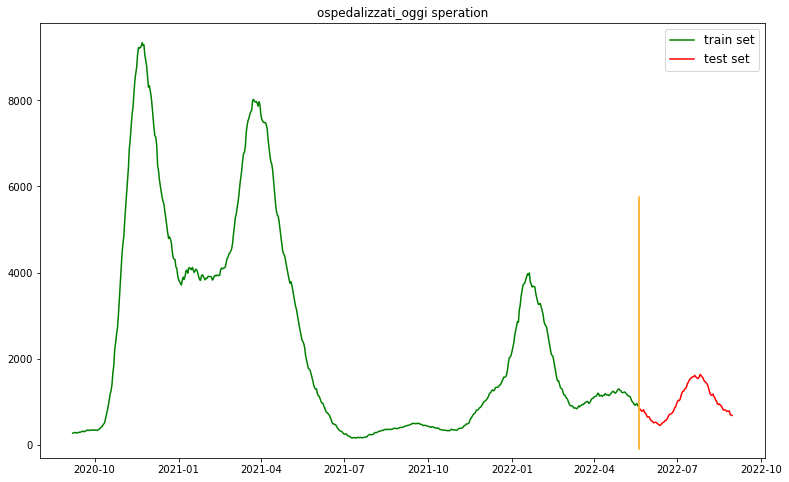

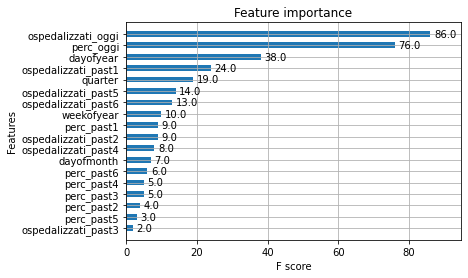

Error on test data after training the model on all training set
Mean Squared Error: 287461.606
Root Mean Sqarred Error: 536.1545
Mean Absolute Error: 421.7288
Mean Absolute Percentage Error: 45.635


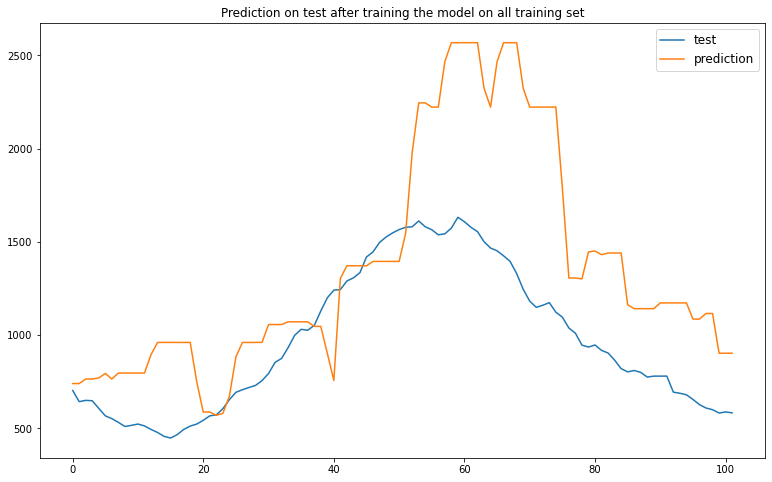

In [8]:
# -> fitting model on entire dataframe
X_train_total = X[X.index < separation_index_train_test]
X_test_total = X[(X.index > separation_index_train_test) & (X.index <= separation_index_prediction)]

y_train_total = y[y.index < separation_index_train_test]
y_test_total = y[(y.index > separation_index_train_test) & (y.index <= separation_index_prediction)]

plt.figure(figsize=(13,8))
plt.plot(X_train_total['ospedalizzati_oggi'],color='green',label='train set')
plt.plot(X_test_total['ospedalizzati_oggi'],color='red',label='test set')
plt.axvline(x=separation_index_train_test, ymin = 0.02, ymax = 0.6, color='orange')
plt.title('ospedalizzati_oggi speration')
plt.legend(prop={'size': 12})
plt.show()

# fitting of xgb model after tuning
best_estimator.fit(X_train_total, y_train_total)

# prediction
y_pred_total = best_estimator.predict(X_test_total)

# feature importance of xgboost
plot_importance(best_estimator,height=0.5)
plt.show()

# error on the first prediction 
print('Error on test data after training the model on all training set')
calcError(y_test_total,y_pred_total)

# plot train vs val
plt.figure(figsize=(13,8))
plt.plot(y_test_total.values,label='test')
plt.plot(y_pred_total,label='prediction')
plt.title('Prediction on test after training the model on all training set')
plt.legend(prop={'size': 12})
plt.show()